In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d NIH Chest X-rays
# !kaggle datasets download -d nih-chest-xrays/data
!kaggle datasets download -d nih-chest-xrays/sample

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
100% 4.19G/4.20G [00:47<00:00, 113MB/s]
100% 4.20G/4.20G [00:47<00:00, 95.4MB/s]


In [2]:
!unzip sample.zip

Streaming output truncated to the last 5000 lines.
  inflating: sample/sample/images/00003124_000.png  
  inflating: sample/sample/images/00003129_000.png  
  inflating: sample/sample/images/00003129_001.png  
  inflating: sample/sample/images/00003129_004.png  
  inflating: sample/sample/images/00003129_009.png  
  inflating: sample/sample/images/00003129_011.png  
  inflating: sample/sample/images/00003135_000.png  
  inflating: sample/sample/images/00003140_007.png  
  inflating: sample/sample/images/00003159_001.png  
  inflating: sample/sample/images/00003169_001.png  
  inflating: sample/sample/images/00003177_002.png  
  inflating: sample/sample/images/00003186_004.png  
  inflating: sample/sample/images/00003186_005.png  
  inflating: sample/sample/images/00003190_018.png  
  inflating: sample/sample/images/00003191_001.png  
  inflating: sample/sample/images/00003198_002.png  
  inflating: sample/sample/images/00003198_005.png  
  inflating: sample/sample/images/00003198_009.p

In [3]:
!rm /content/sample.zip

# **Approach 1 (train-simple-xray-cnn.ipynb)**

# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
all_xray_df['Patient Age']

0         58
1         58
2         58
3         81
4         81
          ..
112115    39
112116    29
112117    42
112118    30
112119    27
Name: Patient Age, Length: 112120, dtype: int64

In [ ]:
all_xray_df = pd.read_csv('./Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 102693 , Total Headers 112120


Image Index                       Finding Labels  Follow-up #  \
82628  00020319_005.png             Atelectasis|Infiltration            5   
44519  00011457_003.png                          Atelectasis            3   
20673  00005532_010.png  Consolidation|Effusion|Infiltration           10   

       Patient ID  Patient Age Patient Gender View Position  \
82628       20319           44              M            PA   
44519       11457           58              M            AP   
20673        5532           39              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
82628                 3056     2516                        0.139  0.139   
44519                 2500     2048                        0.168  0.168   
20673                 2992     2991                        0.143  0.143   

       Unnamed: 11                                path  
82628          NaN  images_009/images/00020319_005.png  
44519          NaN  images_005/images/00011457_003.png  
20673          NaN  images_003/images/00005532_010.png

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

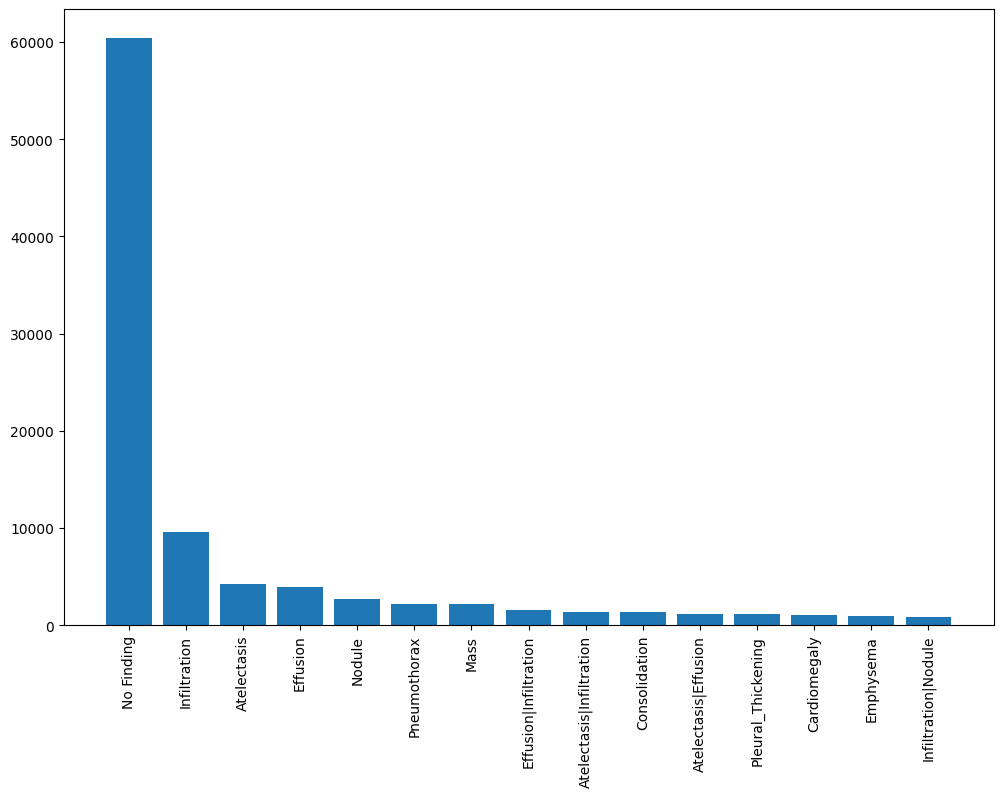

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
30854  00008039_007.png                           7        8039           38   
46316  00011838_001.png                           1       11838           60   
69723  00017180_000.png                           0       17180           52   

      Patient Gender View Position  OriginalImage[Width  Height]  \
30854              M            PA                 2500     2048   
46316              F            PA                 2992     2991   
69723              F            PA                 2992     2991   

       OriginalImagePixelSpacing[x  ...  Effusion  Emphysema Fibrosis  Hernia  \
30854                        0.168  ...       0.0        0.0      0.0     0.0   
46316                        0.143  ...       0.0        0.0      0.0     0.0   
69723                        0.143  ...       0.0        0.0      0.0     0.0   

       Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
30854           0.0   0.0     0.0                 0.0        0.0           0.0  
46316           0.0   0.0     0.0                 0.0        0.0           0.0  
69723           0.0   0.0     0.0                 0.0        0.0           0.0  

[3 rows x 27 columns]

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [ ]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


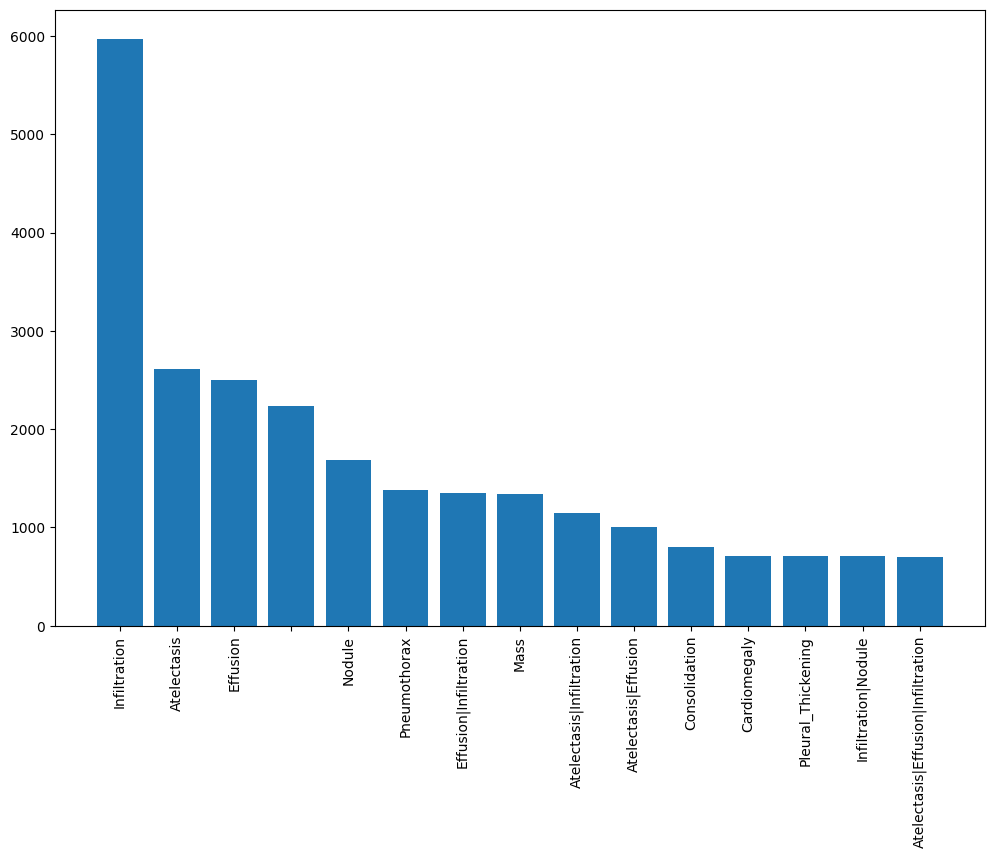

In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

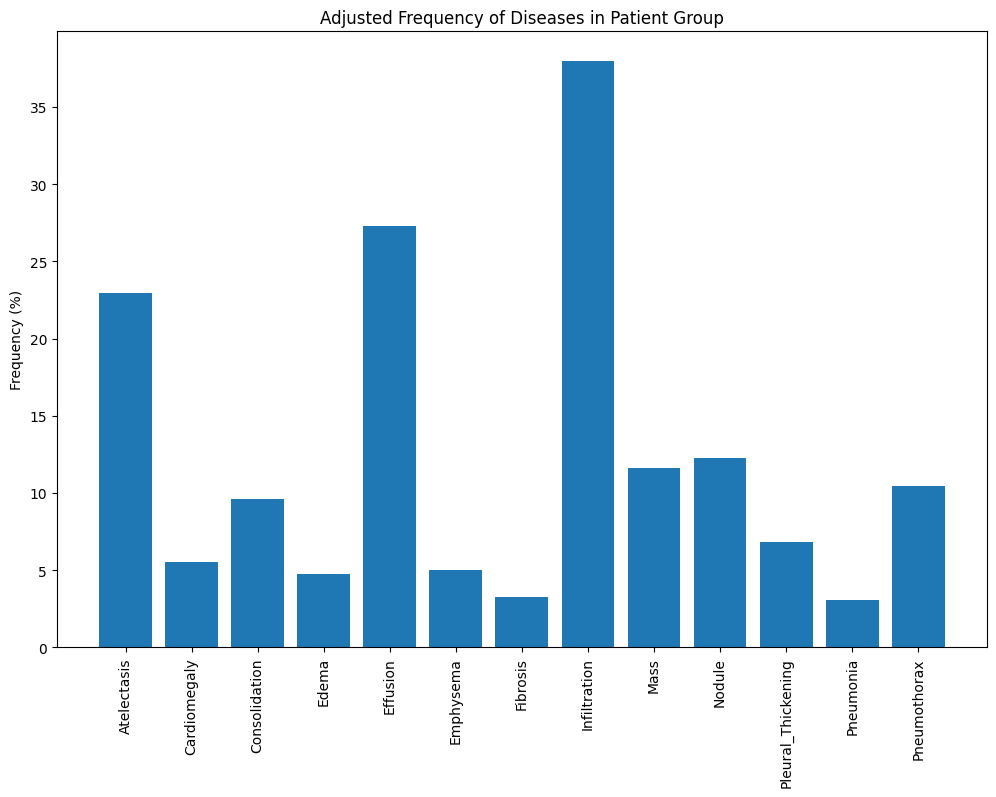

In [ ]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
train_gen = flow_from_dataframe(core_idg, train_df,
                             path_col = 'path',
                            y_col = 'disease_vec',
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df,
                             path_col = 'path',
                            y_col = 'disease_vec',
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg,
                               valid_df,
                             path_col = 'path',
                            y_col = 'disease_vec',
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


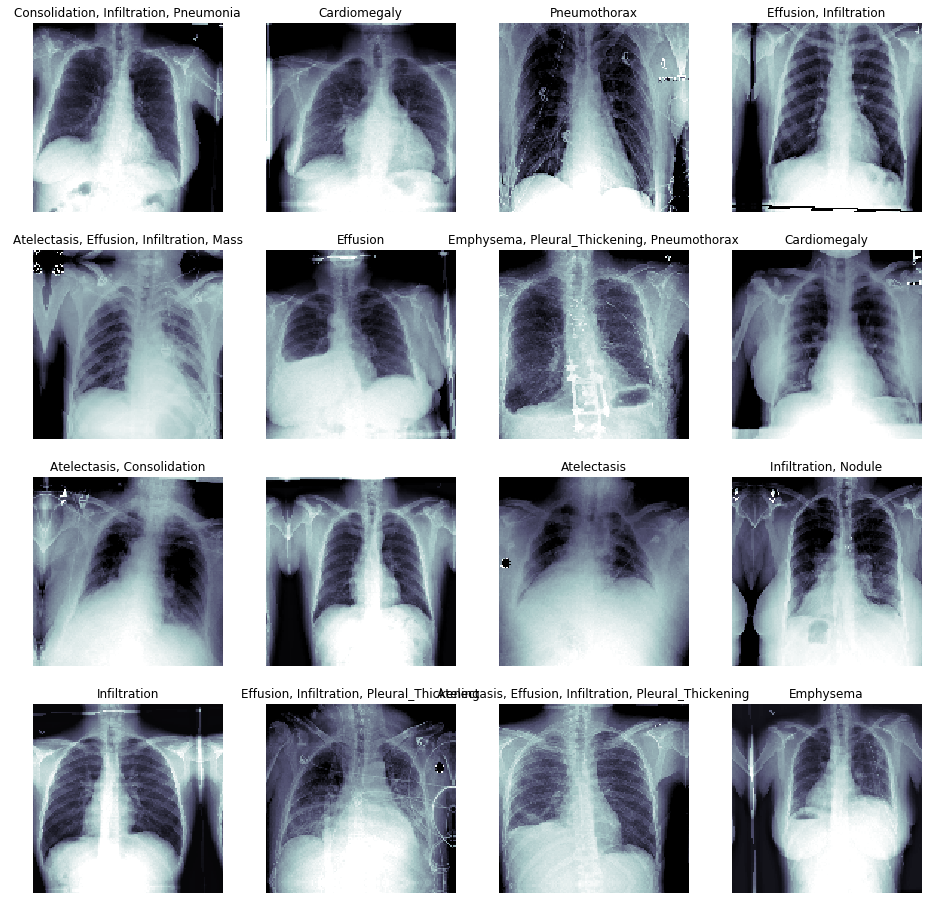

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [ ]:
multi_disease_model.fit_generator(train_gen,
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y),
                                  epochs = 1,
                                  callbacks = callbacks_list)

Epoch 1/1
 99/100 [============================>.] - ETA: 4s - loss: 0.4498 - binary_accuracy: 0.8516 - mean_absolute_error: 0.2011
Epoch 00001: val_loss improved from inf to 0.79686, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 484s 5s/step - loss: 0.4496 - binary_accuracy: 0.8516 - mean_absolute_error: 0.2012 - val_loss: 0.7969 - val_binary_accuracy: 0.8631 - val_mean_absolute_error: 0.1542


# Check Output
Here we see how many positive examples we have of each category

In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 24.41%
Cardiomegaly: 5.18%
Consolidation: 10.55%
Edema: 4.39%
Effusion: 26.27%
Emphysema: 4.69%
Fibrosis: 2.64%
Infiltration: 37.21%
Mass: 11.91%
Nodule: 12.40%
Pleural_Thickening: 5.96%
Pneumonia: 2.73%
Pneumothorax: 11.04%


In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 45s 44ms/step


# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

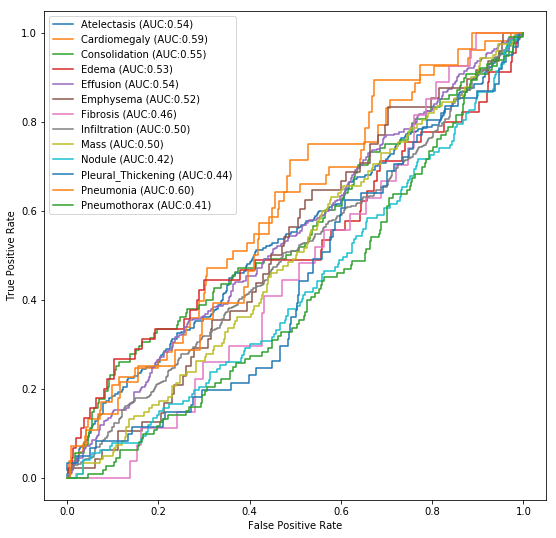

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Continued Training
Now we do a much longer training process to see how the results improve

In [ ]:
multi_disease_model.fit_generator(train_gen,
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y),
                                  epochs = 5,
                                  callbacks = callbacks_list)

Epoch 1/5
 99/100 [============================>.] - ETA: 4s - loss: 0.3723 - binary_accuracy: 0.8664 - mean_absolute_error: 0.1972
Epoch 00001: val_loss improved from 0.79686 to 0.34932, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 483s 5s/step - loss: 0.3721 - binary_accuracy: 0.8666 - mean_absolute_error: 0.1972 - val_loss: 0.3493 - val_binary_accuracy: 0.8738 - val_mean_absolute_error: 0.2016
Epoch 2/5
 99/100 [============================>.] - ETA: 4s - loss: 0.3494 - binary_accuracy: 0.8718 - mean_absolute_error: 0.1990
Epoch 00002: val_loss did not improve
100/100 [==============================] - 490s 5s/step - loss: 0.3495 - binary_accuracy: 0.8718 - mean_absolute_error: 0.1991 - val_loss: 0.3515 - val_binary_accuracy: 0.8616 - val_mean_absolute_error: 0.2050
Epoch 3/5
 99/100 [============================>.] - ETA: 4s - loss: 0.3417 - binary_accuracy: 0.8727 - mean_absolute_error: 0.1985
Epoch 00003: val_loss did not improve
100/100

In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 34s 34ms/step


In [ ]:
# look at how often the algorithm predicts certain diagnoses
for c_label, p_count, t_count in zip(all_labels,
                                     100*np.mean(pred_Y,0),
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 24.41%, PDx: 25.93%
Cardiomegaly: Dx: 5.18%, PDx: 3.92%
Consolidation: Dx: 10.55%, PDx: 13.94%
Edema: Dx: 4.39%, PDx: 7.24%
Effusion: Dx: 26.27%, PDx: 26.18%
Emphysema: Dx: 4.69%, PDx: 2.29%
Fibrosis: Dx: 2.64%, PDx: 3.05%
Infiltration: Dx: 37.21%, PDx: 49.67%
Mass: Dx: 11.91%, PDx: 9.15%
Nodule: Dx: 12.40%, PDx: 9.72%
Pleural_Thickening: Dx: 5.96%, PDx: 5.32%
Pneumonia: Dx: 2.73%, PDx: 4.52%
Pneumothorax: Dx: 11.04%, PDx: 6.85%


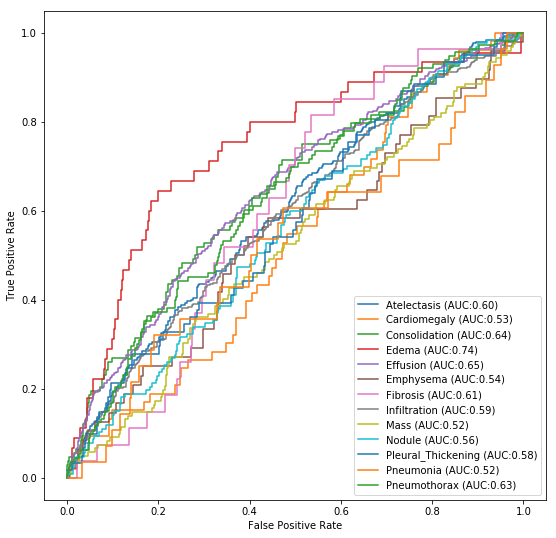

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

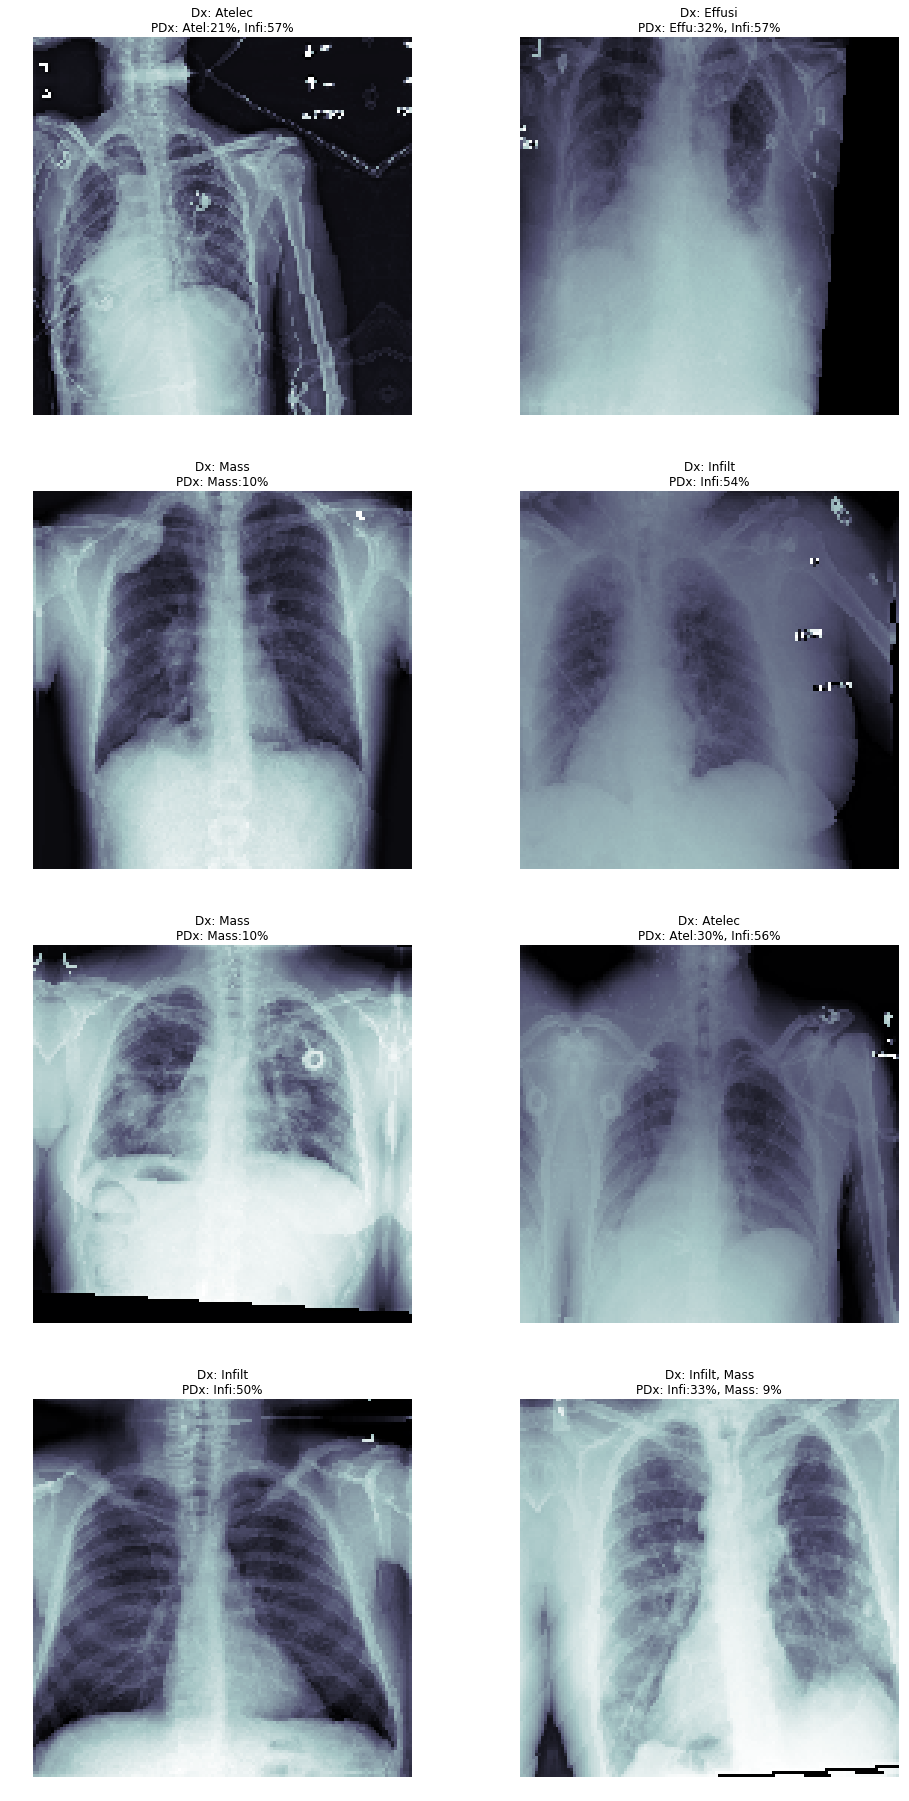

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

grad cam visualization

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import (
    ResNet50,
    preprocess_input,
    decode_predictions,
)
import cv2

sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

# **Approach 2 (nih.ipynb)**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = cv2.imread('/content/com/datasets/nih-chest-xrays/data/Normal/images/Normal-1.png')

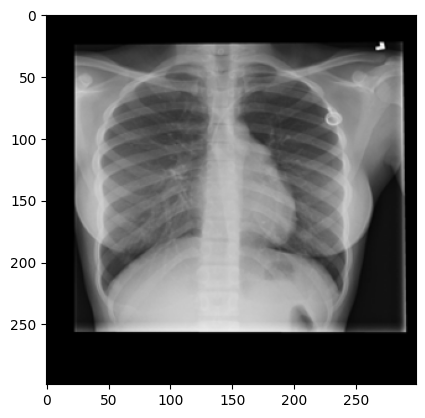

In [ ]:
plt.imshow(img)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os

In [ ]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(len(urls)):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img = img / 255.0
    #print(img_path)
    # if we want to resize the images
    img = cv2.resize(img, (100, 100))
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels

In [ ]:
nih_path = "/content/com/datasets/nih-chest-xrays/data/images"
nih_Url = os.listdir(nih_path)
nih_Images, nih_Targets = loadImages(nih_path, nih_Url, 1)

In [ ]:
len(nih_Url), len(nih_Images)

(3616, 3616)

In [ ]:
normal_path = "/content/com/datasets/nih-chest-xrays/data/Normal/images"
normal_urls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normal_urls, 0)

In [ ]:
targets = np.r_[nih_Targets, normalTargets]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.25)

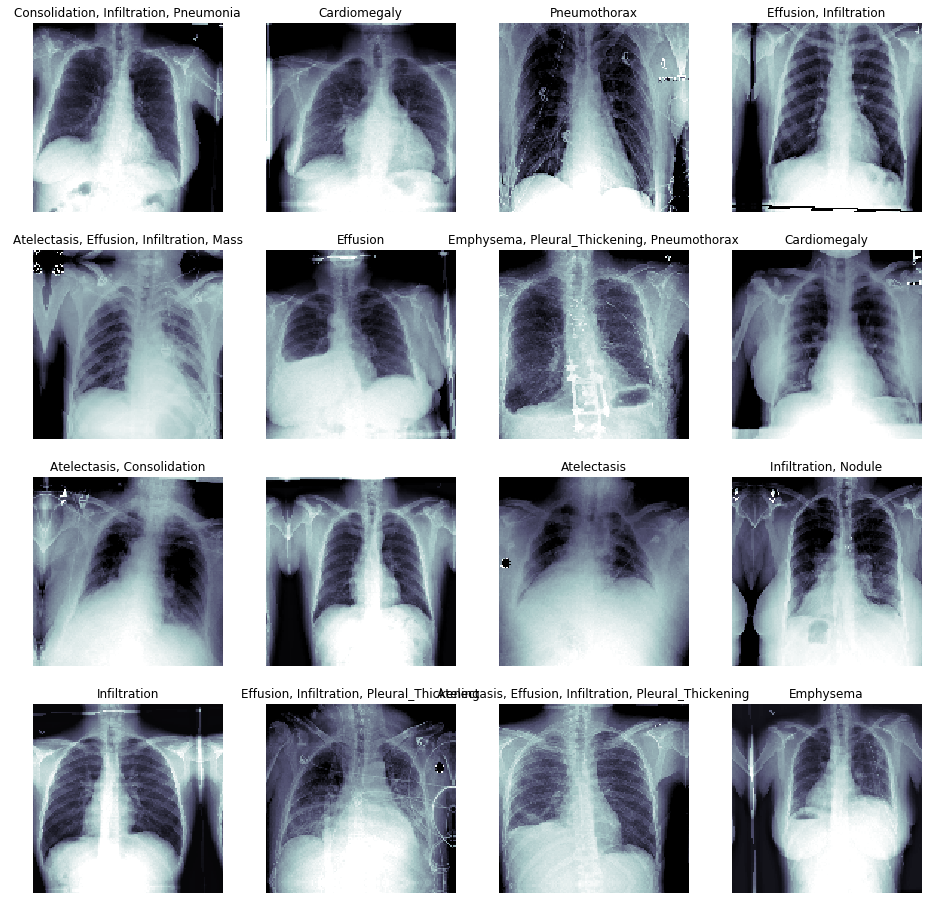

In [ ]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential([
    Conv2D(32, 3, input_shape=(100,100,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

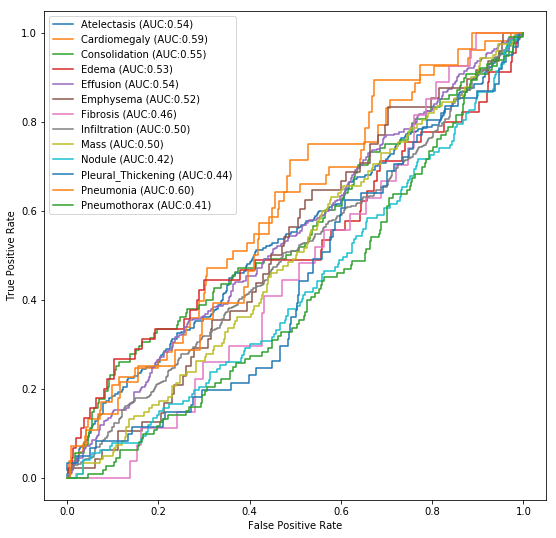

In [ ]:
from sklearn.metrics import auc, roc_curve

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test))

Epoch 1/5
324/324 [==============================] - 10s 12ms/step - loss: 0.3969 - accuracy: 0.8218 - val_loss: 0.3045 - val_accuracy: 0.8630
Epoch 2/5
324/324 [==============================] - 2s 7ms/step - loss: 0.2666 - accuracy: 0.8893 - val_loss: 0.2448 - val_accuracy: 0.8905
Epoch 3/5
324/324 [==============================] - 2s 7ms/step - loss: 0.2091 - accuracy: 0.9164 - val_loss: 0.1858 - val_accuracy: 0.9293
Epoch 4/5
324/324 [==============================] - 2s 7ms/step - loss: 0.1708 - accuracy: 0.9303 - val_loss: 0.1764 - val_accuracy: 0.9267
Epoch 5/5
324/324 [==============================] - 2s 7ms/step - loss: 0.1324 - accuracy: 0.9479 - val_loss: 0.1649 - val_accuracy: 0.9308


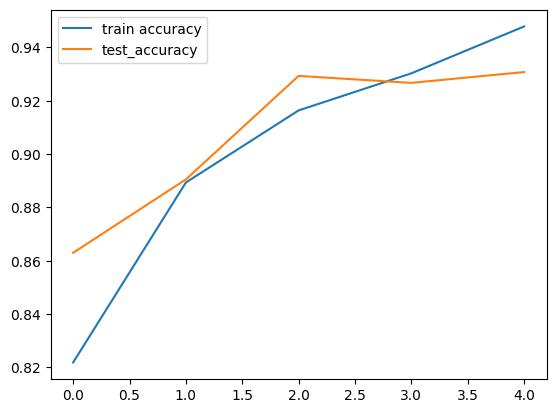

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

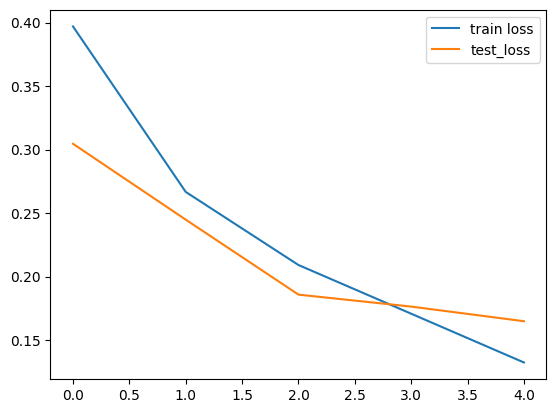

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

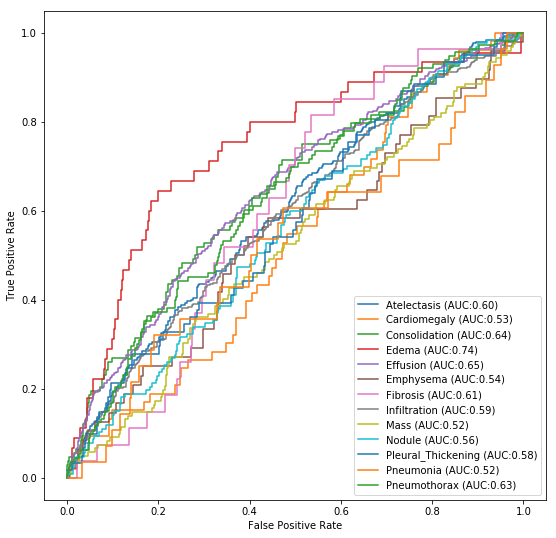

In [ ]:
from sklearn.metrics import auc, roc_curve

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
# prompt: also find f1 score precision and confusion matric

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(x_test)

f1_score = classification_report(y_test, np.round(y_pred), output_dict=True)['1']['f1-score']
precision = classification_report(y_test, np.round(y_pred), output_dict=True)['1']['precision']
confusion_matrix = confusion_matrix(y_test, np.round(y_pred))

print("f1 score:", f1_score)
print("precision:", precision)
print("confusion matrix:", confusion_matrix)

108/108 [==============================] - 0s 3ms/step
f1 score: 0.8625646923519262
precision: 0.8971291866028708
confusion matrix: [[2463   86]
 [ 153  750]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
threshold = 0.5

In [ ]:
y_pred_binary = [1 if prob >= threshold else 0 for prob in y_pred]

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)

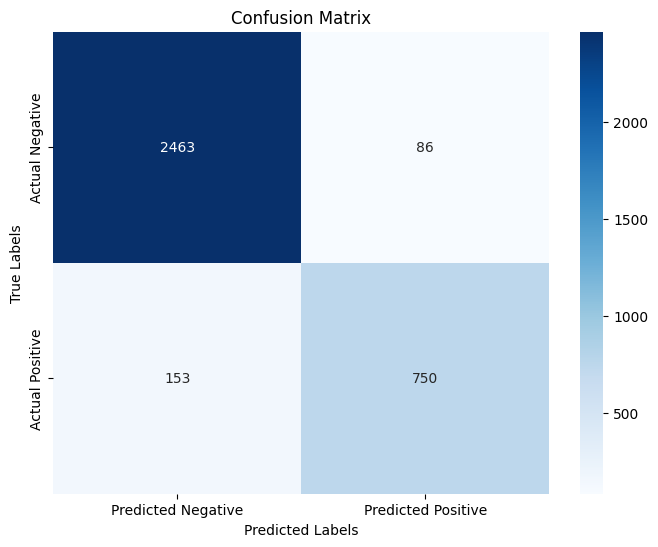

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# prompt: save the model

model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

In [ ]:
for i in model.layers:
    print(i.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dense_1
dense_2


In [ ]:
# Import necessary libraries
from PIL import Image
from matplotlib import cm
import sys

# Define function to generate Grad-CAM visualization for given image and CNN model
def grad_cam(model, image, layer_name):

    # Define model that generates both final model predictions as well as output of chosen layer
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # Incoming image is singular example so expand dimensions to represent batch of size 1
    image_tensor = np.expand_dims(image, axis=0)

    # Cast image tensor to float32 type
    inputs = tf.cast(image_tensor, tf.float32)

    # Set up gradient tape to monitor intermediate variables and predictions
    with tf.GradientTape() as tape:

        # Extract activations from chosen layer and model's final predictions
        last_conv_layer_output, preds = grad_model(inputs)

        # Identify predicted class from final predictions
        pred_class = tf.argmax(preds[0])

        # Get output of predicted class from final layer
        class_channel = preds[:, pred_class]

    # Compute gradient of output with respect to chosen layer's output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Reduce 2D gradients to 1D by averaging across height and width dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply 2D output map of chosen layer by 1D pooled gradients
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to be between 0 and 1 for better visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Return Grad-CAM heatmap
    return heatmap.numpy()

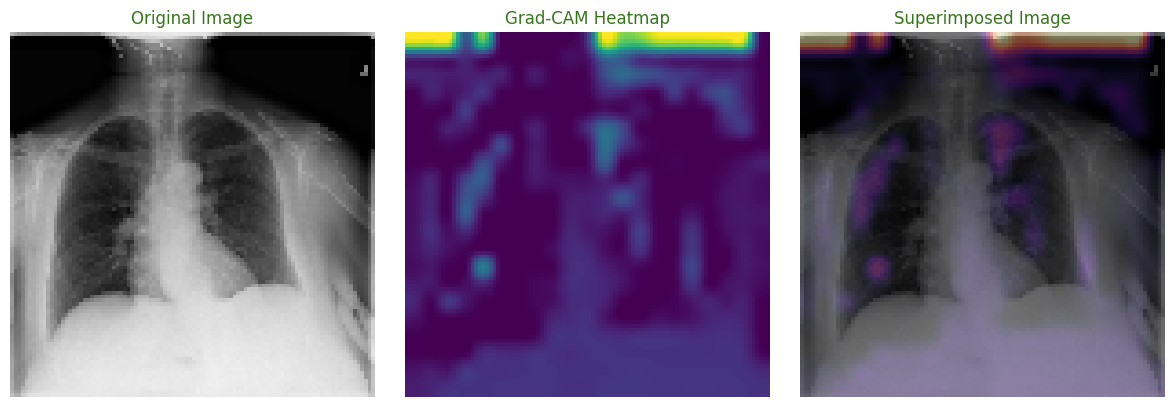

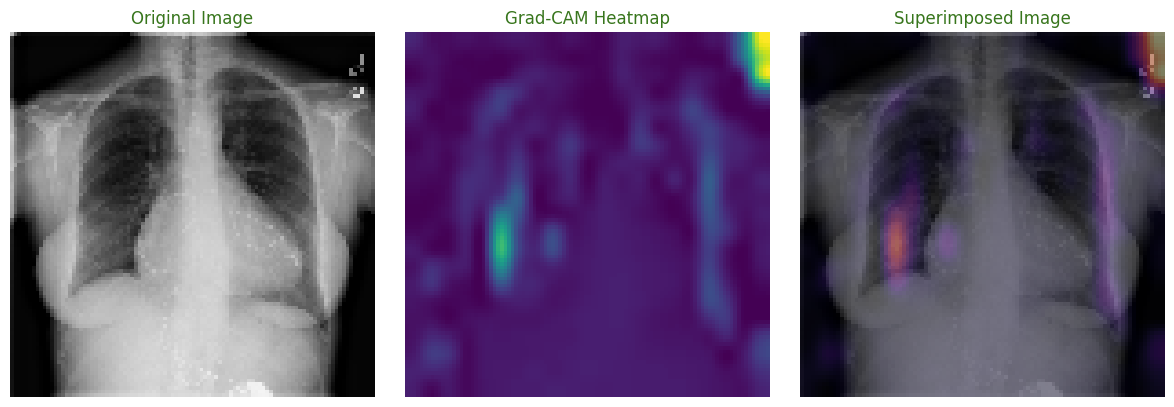

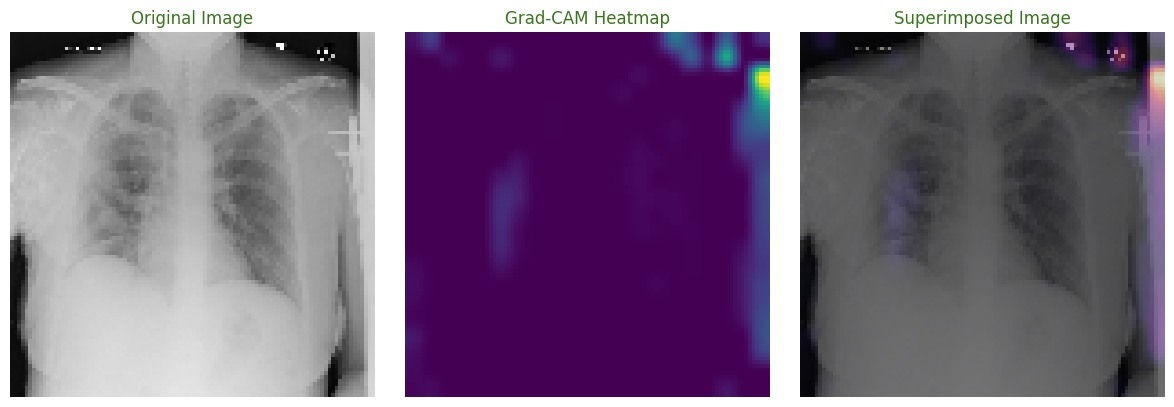

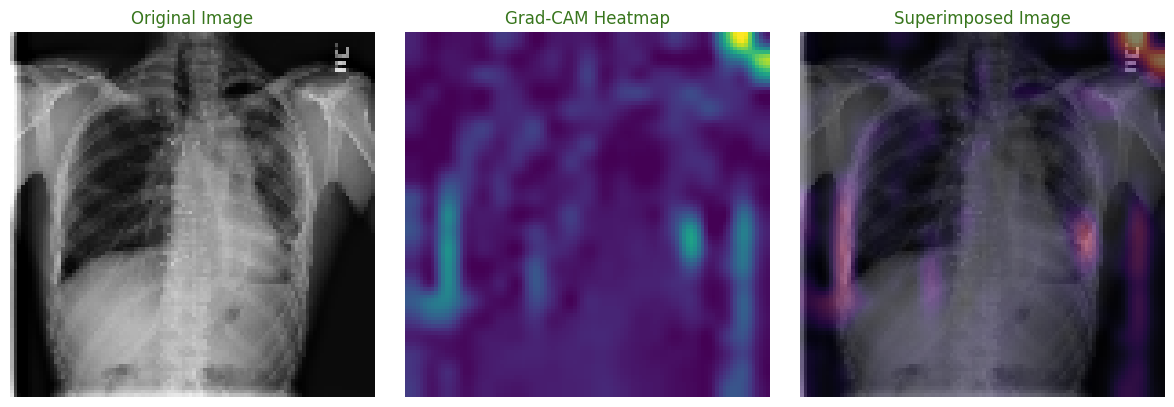

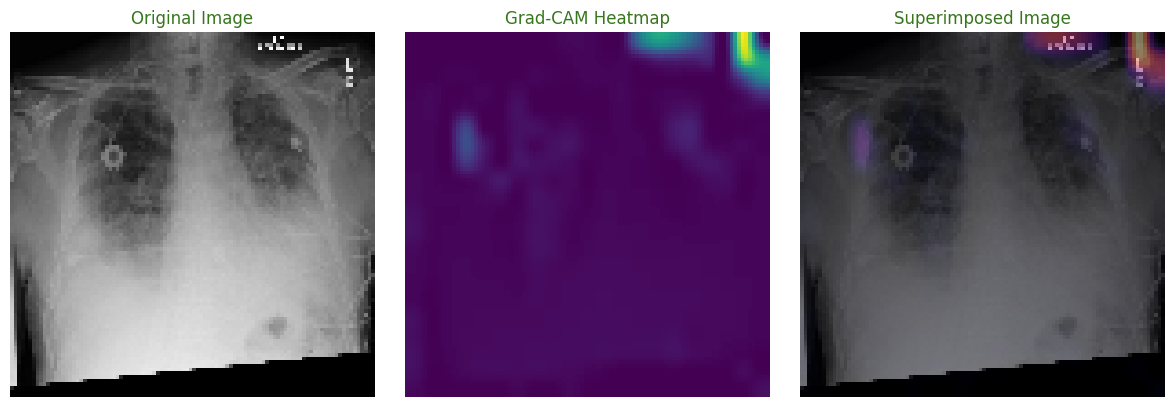

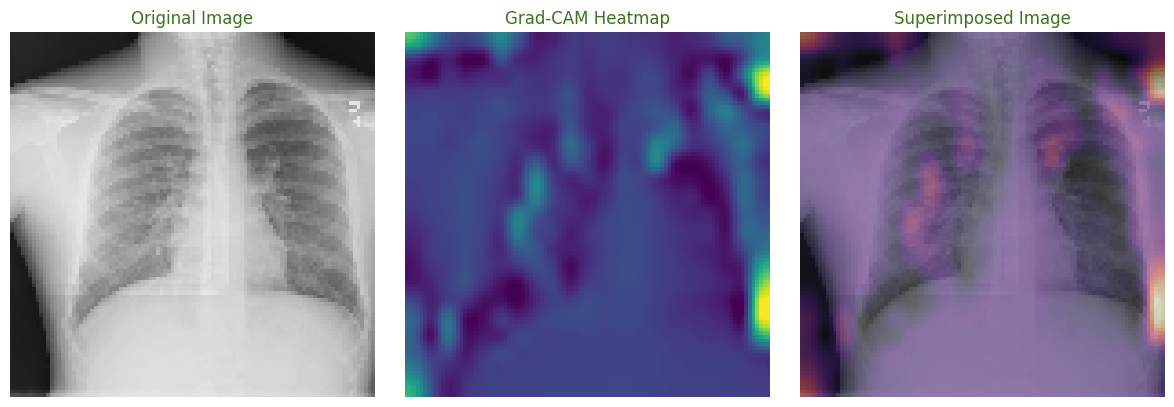

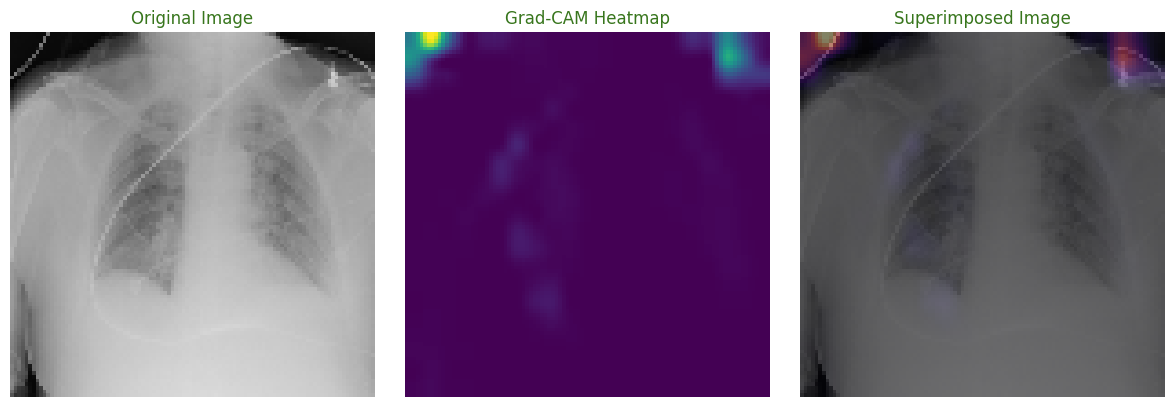

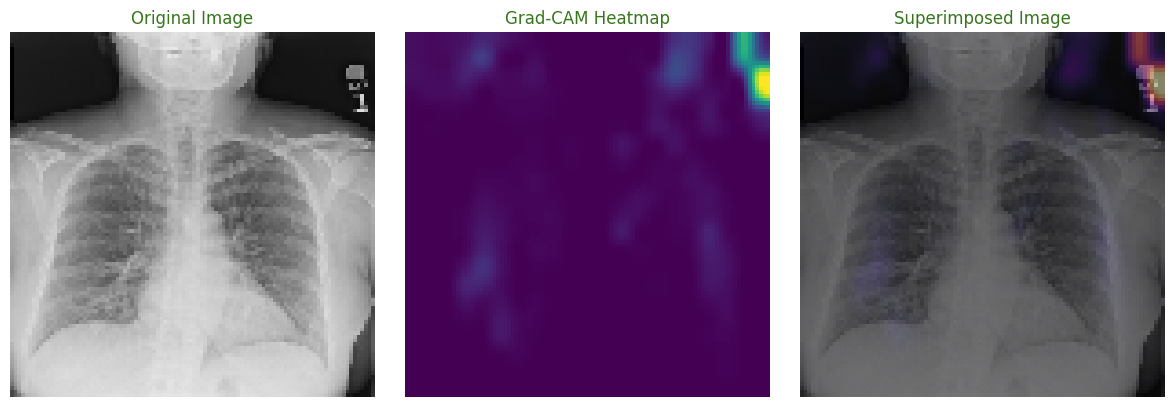

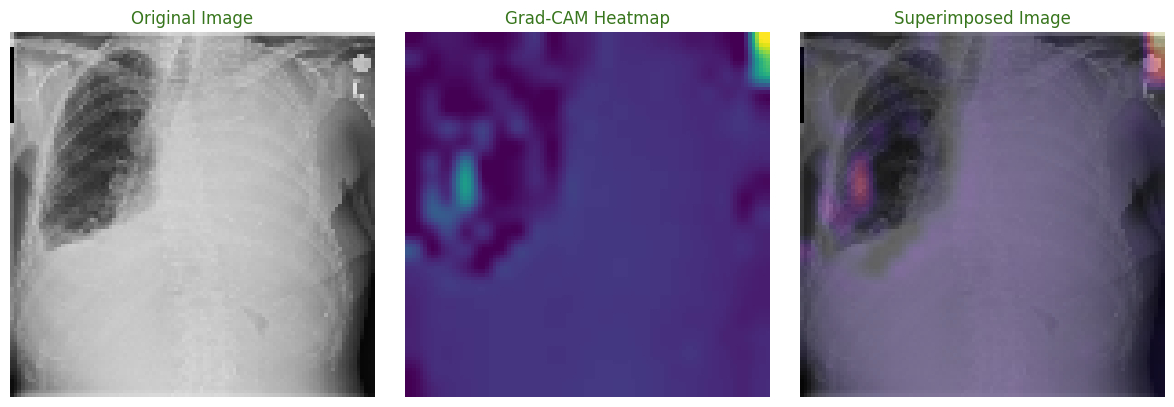

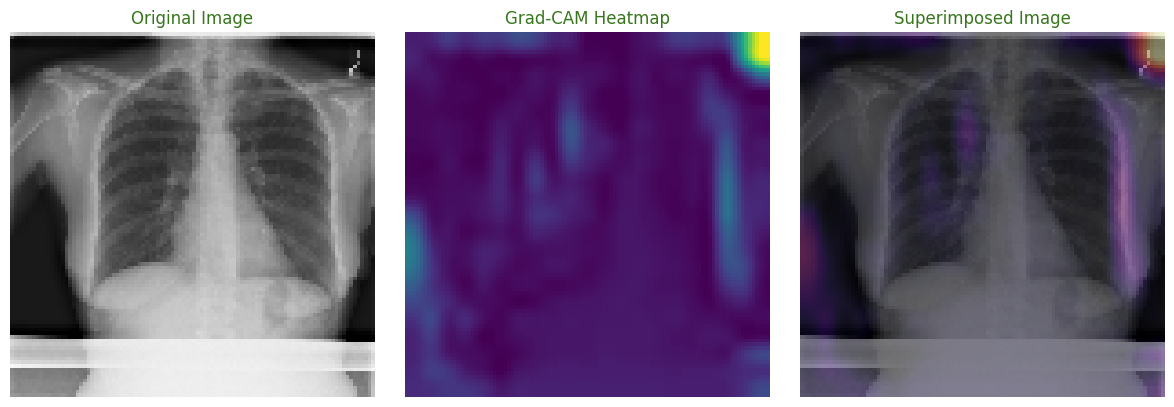

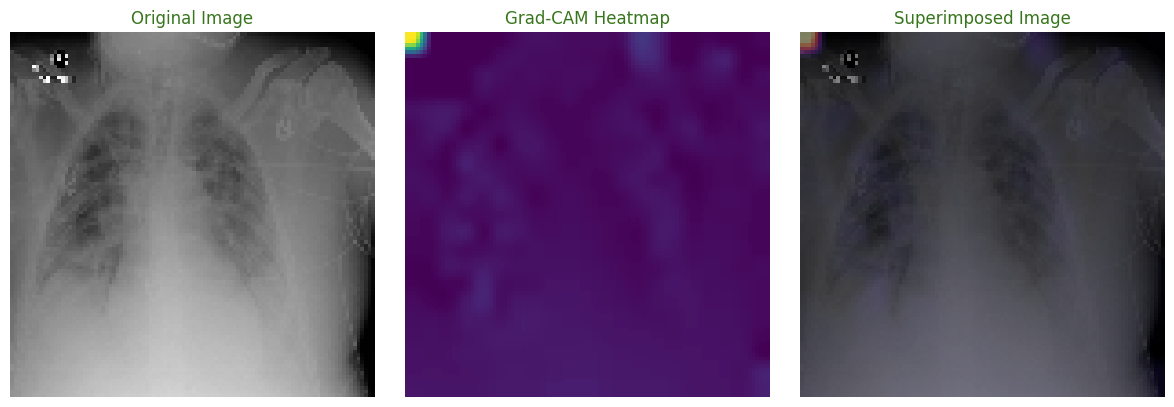

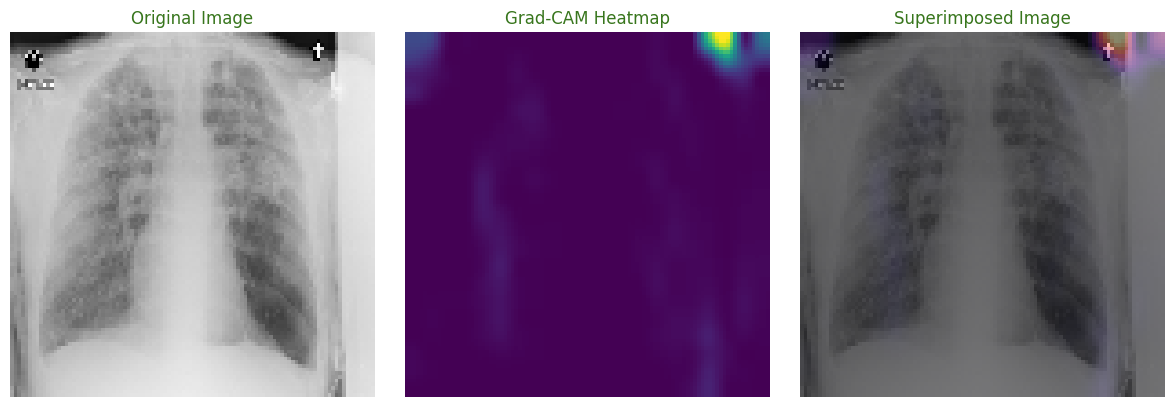

In [ ]:
import glob
import cv2
import numpy as np
import tensorflow as tf
# Set number of images to display and generate random indices
num_images = 12
test_images = [i for i in glob.glob("/content/images_001/images/*.png")]
image_indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Set layer name based on best performing CNN model for Grad-CAM visualization
layer_name = 'conv2d_2'

# Loop over random indices to generate Grad-CAM visualizations for multiple test images
for image_index in image_indices:

    # Choose test image and visualize using Grad-CAM
    image = cv2.imread(test_images[image_index])
    image = cv2.resize(image,(100,100))/255.0
    cv2.imwrite('original.png', 255*image)
    grad_cam_image = grad_cam(model, image, layer_name)

    # Enhance heatmap image for better visualization
    grad_cam_image = np.maximum(grad_cam_image, 0)
    grad_cam_image = np.minimum(grad_cam_image, 1)
    heatmap_colored = np.uint8(255 * grad_cam_image)
    # heatmap_colored = cm.jet(grad_cam_image)[:, :, :3]
    # heatmap_colored = np.uint8(255 * heatmap_colored)

    # Resize heatmap to original image size
    heatmap_resized = np.array(Image.fromarray(heatmap_colored).resize((image.shape[1], image.shape[0])))

    # Convert image and heatmap to 0-255 scale
    if image.max() <= 1:
        image = (image * 255).astype('uint8')
    if heatmap_resized.max() <= 1:
        heatmap_resized = (heatmap_resized * 255).astype('uint8')

    # Superimpose heatmap on original image, with more weight on original image
    # superimposed_image = heatmap_resized * 0.4 + image * 0.6
    # superimposed_image = np.clip(superimposed_image, 0, 255).astype('uint8')

    # Temporarily redirect standard output to null to suppress verbose output
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    # # Predict class of image using final hybrid model
    # test_feature = best_cnn_model.predict(np.expand_dims(image, axis=0))
    # predicted_class = final_hybrid_model.predict(test_feature)
    # predicted_class_name = class_names[np.argmax(predicted_class)]
    # actual_class_name = class_names[np.argmax(test_labels_xgb[image_index])]

    # Restore standard output to original state
    sys.stdout = original_stdout

    # Determine if prediction is correct
    # is_correct = (actual_class_name == predicted_class_name)

    # Assign title color based on prediction correctness
    title_color = '#38761D'

    # Set up plot for original, heatmap and superimposed images
    plt.figure(figsize=(12, 4))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Original Image', color=title_color)
    plt.axis('off')

    # Plot heatmap image
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized)
    plt.title('Grad-CAM Heatmap', color=title_color)
    plt.axis('off')

    # Plot superimposed image
    plt.subplot(1, 3, 3)
    # plt.imshow(superimposed_image.astype(np.uint8))
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap_resized, cmap='magma', alpha=0.5)
    plt.title(f'Superimposed Image', color=title_color)
    # Convert heatmap to a colored heatmap using a colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_MAGMA)

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

    # Save the resulting image
    cv2.imwrite('merged_image.jpg', overlay)
    plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
!mkdir static

In [ ]:
# cv2.imwrite("./static/gradcamheatmap.png",cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB))
# cv2.imwrite("./static/gradcamsuperimposed.png",cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))

True

# **Approach 3> transfer learning**

In [4]:
import pandas as pd

data = pd.read_csv("/content/sample/sample_labels.csv")
data.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168

In [5]:
import glob
import os

imgs = [os.path.basename(i) for i in glob.glob("/content/sample/images/*")]
print(len(imgs))
print(imgs)

5606
['00020190_002.png', '00011678_000.png', '00016177_009.png', '00010613_009.png', '00007193_012.png', '00010698_014.png', '00018027_007.png', '00016246_000.png', '00027066_004.png', '00027726_004.png', '00006024_009.png', '00017642_000.png', '00024680_000.png', '00026975_002.png', '00017206_001.png', '00005460_011.png', '00004604_001.png', '00018175_006.png', '00007093_006.png', '00014355_004.png', '00019549_004.png', '00010552_005.png', '00003868_001.png', '00003382_008.png', '00027213_086.png', '00004067_000.png', '00008451_004.png', '00015794_003.png', '00012748_000.png', '00023273_000.png', '00011193_001.png', '00018251_006.png', '00021489_014.png', '00010563_016.png', '00019216_003.png', '00026099_009.png', '00007882_002.png', '00015266_010.png', '00004911_033.png', '00011385_002.png', '00018191_005.png', '00007109_021.png', '00004090_000.png', '00004867_000.png', '00002300_016.png', '00025290_036.png', '00026236_021.png', '00014571_002.png', '00002860_002.png', '00021117_000.

In [6]:
from tqdm import tqdm
inds = []
for j in tqdm(range(len(imgs))):
    inds.append(data.index[data['Image Index'] == imgs[j]].tolist()[0])
print(inds)

100%|██████████| 5606/5606 [00:05<00:00, 1106.84it/s]

[4093, 2276, 3277, 2047, 1388, 2065, 3669, 3292, 5092, 5191, 1146, 3572, 4749, 5077, 3493, 1047, 874, 3701, 1363, 2912, 3958, 2035, 737, 650, 5118, 773, 1624, 3210, 2537, 4649, 2172, 3718, 4351, 2038, 3897, 4948, 1510, 3101, 945, 2205, 3707, 1369, 780, 933, 430, 4809, 4980, 2961, 556, 4278, 3008, 2806, 4811, 4869, 1014, 4658, 188, 3224, 333, 4986, 5602, 1170, 3135, 5541, 4531, 4448, 5526, 5592, 4449, 4320, 5424, 227, 3221, 4917, 1615, 5093, 3996, 4062, 4490, 2573, 1714, 3487, 5466, 4410, 3802, 3170, 5594, 2911, 823, 3349, 576, 3409, 4485, 4419, 5446, 4746, 4277, 2518, 44, 5396, 2064, 51, 4220, 5250, 3895, 2560, 976, 1839, 458, 2362, 3478, 436, 301, 1204, 622, 3500, 5255, 4231, 4858, 2508, 1025, 2773, 1177, 3495, 265, 5291, 3923, 43, 3518, 4108, 4358, 460, 5001, 3139, 3678, 2566, 3276, 3005, 1851, 1321, 641, 4848, 4005, 5030, 1999, 4239, 3513, 5345, 974, 4549, 2085, 4607, 1858, 5545, 1930, 2783, 3710, 1301, 4374, 3317, 3675, 4458, 4510, 2321, 1376, 4820, 684, 3384, 4234, 5087, 3912, 763

In [7]:
df = data.loc[inds]
df.reset_index(drop=True, inplace=True)
df

Image Index                               Finding Labels  \
0     00020190_002.png                                  Atelectasis   
1     00011678_000.png                                  Atelectasis   
2     00016177_009.png                                   No Finding   
3     00010613_009.png                                   No Finding   
4     00007193_012.png                                 Infiltration   
...                ...                                          ...   
5601  00007328_012.png                                   No Finding   
5602  00004808_022.png                                   No Finding   
5603  00017645_007.png                                       Nodule   
5604  00016778_003.png  Atelectasis|Infiltration|Pleural_Thickening   
5605  00003186_004.png                           Edema|Infiltration   

      Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0               2       20190        057Y              M            PA   
1               0       11678        055Y              M            PA   
2               9       16177        054Y              M            PA   
3               9       10613        056Y              M            PA   
4              12        7193        048Y              F            AP   
...           ...         ...         ...            ...           ...   
5601           12        7328        041Y              M            AP   
5602           22        4808        035Y              M            AP   
5603            7       17645        048Y              F            PA   
5604            3       16778        025Y              M            AP   
5605            4        3186        047Y              F            AP   

      OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                   2992                 2991                        0.143   
1                   2992                 2991                        0.143   
2                   2992                 2991                        0.143   
3                   2992                 2991                        0.143   
4                   2500                 2048                        0.168   
...                  ...                  ...                          ...   
5601                2500                 2048                        0.171   
5602                2500                 2048                        0.168   
5603                2992                 2991                        0.143   
5604                3056                 2544                        0.139   
5605                2500                 2048                        0.171   

      OriginalImagePixelSpacing_y  
0                           0.143  
1                           0.143  
2                           0.143  
3                           0.143  
4                           0.168  
...                           ...  
5601                        0.171  
5602                        0.168  
5603                        0.143  
5604                        0.139  
5605                        0.171  

[5606 rows x 11 columns]

In [ ]:
[i for i in df['Finding Labels'].unique() if "Cardiomegaly" in i]

['Cardiomegaly|Edema',
 'Cardiomegaly|Effusion',
 'Atelectasis|Cardiomegaly|Effusion',
 'Cardiomegaly|Consolidation|Effusion',
 'Cardiomegaly',
 'Cardiomegaly|Consolidation|Effusion|Mass|Pneumothorax',
 'Cardiomegaly|Infiltration',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening',
 'Cardiomegaly|Effusion|Nodule',
 'Atelectasis|Cardiomegaly',
 'Cardiomegaly|Pleural_Thickening',
 'Cardiomegaly|Effusion|Infiltration',
 'Cardiomegaly|Effusion|Infiltration|Nodule',
 'Cardiomegaly|Consolidation|Pneumonia',
 'Cardiomegaly|Consolidation|Infiltration',
 'Cardiomegaly|Effusion|Mass|Pneumothorax',
 'Cardiomegaly|Effusion|Fibrosis',
 'Cardiomegaly|Emphysema',
 'Cardiomegaly|Edema|Mass',
 'Cardiomegaly|Mass',
 'Atelectasis|Cardiomegaly|Effusion|Fibrosis|Nodule',
 'Cardiomegaly|Edema|Infiltration|Nodule',
 'Atelectasis|Cardiomegaly|Effusion|Fibrosis|Infiltration',
 'Cardiomegaly|Edema|Effusion',
 'Atelectasis|Cardiomegaly|Effusion|Infiltration|Pleural_Thickenin

In [ ]:
# !rm -rf dataset

In [8]:
!mkdir dataset
!mkdir dataset/Cardiomegaly
!mkdir dataset/nonCardiomegaly

In [9]:
import glob
import os
from tqdm import tqdm
import cv2
import shutil

for j,i in enumerate(tqdm(glob.glob("/content/sample/images/*"))):
    img = cv2.imread(i)
    # img = cv2.resize(img, (256,256))
    ind = df.index[df['Image Index'] == os.path.basename(i)].tolist()[0]
    if "Cardiomegaly" in df.iloc[ind]['Finding Labels']:
        # cv2.imwrite(f"/content/dataset/Cardiomegaly/{j}.png", img)
        shutil.copy2(i,f"/content/dataset/Cardiomegaly/{j}.png")
    else:
        # cv2.imwrite(f"/content/dataset/nonCardiomegaly/{j}.png", img)
        shutil.copy2(i,f"/content/dataset/nonCardiomegaly/{j}.png")

    # break

100%|██████████| 5606/5606 [01:54<00:00, 48.96it/s]


class imbalance

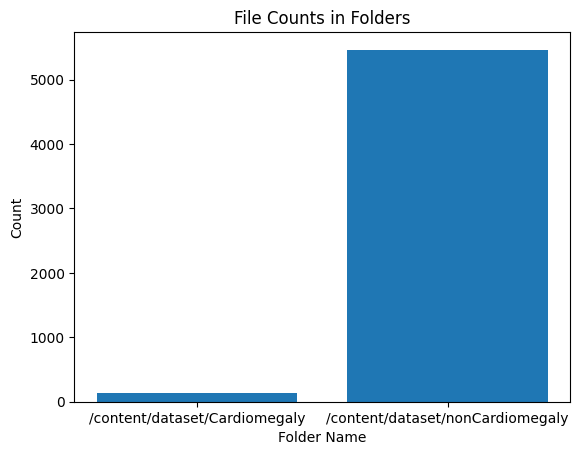

In [21]:
import os
import matplotlib.pyplot as plt

# Replace 'folder1' and 'folder2' with your actual folder names
folders = ['/content/dataset/Cardiomegaly', '/content/dataset/nonCardiomegaly']
counts = [len(os.listdir(folder)) for folder in folders]

plt.bar(folders, counts)
plt.xlabel('Folder Name')
plt.ylabel('Count')
plt.title('File Counts in Folders')
plt.show()

In [ ]:
counts

[141, 5465]

In [49]:
!mkdir balanced_dataset
!mkdir balanced_dataset/Cardiomegaly
!mkdir balanced_dataset/nonCardiomegaly

In [48]:
# !rm -rf balanced_dataset

In [51]:
import os
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.utils import resample
import shutil

# Define paths
data_dir = '/content/dataset'
output_dir = '/content/balanced_dataset'
classes = ['Cardiomegaly', 'nonCardiomegaly']

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    for cls in classes:
        os.makedirs(os.path.join(output_dir, cls))

# Collect file paths
file_paths = {cls: [] for cls in classes}
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    file_paths[cls] = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]

# Oversample the minority class
max_samples = max(len(file_paths[cls]) for cls in classes)
oversampled_paths = {cls: resample(paths, replace=True, n_samples=max_samples, random_state=42) for cls, paths in file_paths.items()}

# Copy files to the output directory
for cls, paths in oversampled_paths.items():
    for path in paths:
        shutil.copy(path, os.path.join(output_dir, cls, os.path.basename(path)))

In [52]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Set paths
data_dir = '/content/dataset'

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    output_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

base_model = Xception(input_shape = (224, 224, 1), include_top = False, weights = None)
# model = Sequential()
x = base_model.output
# model.add(base_model)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(600)(x)
x = Dropout(0.4)(x)
x = Dense(64)(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights
)

Found 2813 images belonging to 2 classes.
Found 702 images belonging to 2 classes.
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         288       ['input_10[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_c

In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from sklearn.utils.class_weight import compute_class_weight

# # Set paths
# data_dir = '/content/dataset'

# # Create ImageDataGenerators
# train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
# val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     data_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='training'
# )

# val_generator = val_datagen.flow_from_directory(
#     data_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'
# )

# # Calculate class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )
# class_weights = dict(enumerate(class_weights))

# # Load the pre-trained model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Add custom layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator),
#     validation_data=val_generator,
#     epochs=10,
#     class_weight=class_weights
# )

# # Unfreeze some layers of the base model and fine-tune
# for layer in base_model.layers[-50:]:
#     layer.trainable = True

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator),
#     validation_data=val_generator,
#     epochs=10,
#     class_weight=class_weights
# )

Found 4485 images belonging to 2 classes.
Found 1121 images belonging to 2 classes.
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
141/141 [==============================] - 115s 748ms/step - loss: 1.0383 - accuracy: 0.4321 - val_loss: 0.6750 - val_accuracy: 0.9483
Epoch 2/10
141/141 [==============================] - 105s 744ms/step - loss: 0.7755 - accuracy: 0.4814 - val_loss: 0.5224 - val_accuracy: 0.9750
Epoch 3/10
141/141 [==============================] - 101s 718ms/step - loss: 0.7416 - accuracy: 0.4125 - val_loss: 0.4955 - val_accuracy: 0.9750
Epoch 4/10
141/141 [==============================] - 104s 735ms/step - loss: 0.7231 - accuracy: 0.5122 - val_loss: 0.4648 - val_accuracy: 0.9750
Epoch 5/10
141/141 [==============================] - 102s 723ms/step - loss: 0.7151 - accuracy: 0.4557 - val_loss: 0.5008 - val_accuracy: 0.9750
Epoch 6/10
141/141 [==============================] - 117s 832ms/step - loss: 0.7002 - accuracy: 0.4876 - val_loss: 0.983

In [12]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create ImageDataGenerators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     horizontal_flip=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_directory(
#     output_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     color_mode='grayscale',
#     subset='training'
# )

# val_generator = train_datagen.flow_from_directory(
#     output_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     color_mode='grayscale',
#     subset='validation'
# )

Found 226 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Load the pre-trained model
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Add custom layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator),
#     validation_data=val_generator,
#     epochs=10
# )

# # Unfreeze some layers of the base model and fine-tune
# for layer in base_model.layers[-50:]:
#     layer.trainable = True

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_steps=len(val_generator),
#     validation_data=val_generator,
#     epochs=10
# )

Epoch 1/10
8/8 [==============================] - 14s 1s/step - loss: 1.0248 - accuracy: 0.4558 - val_loss: 0.7508 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 8s 1s/step - loss: 0.8447 - accuracy: 0.4912 - val_loss: 0.7465 - val_accuracy: 0.5000
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 0.7351 - accuracy: 0.5044 - val_loss: 0.7677 - val_accuracy: 0.5000
Epoch 4/10
8/8 [==============================] - 7s 938ms/step - loss: 0.6866 - accuracy: 0.5575 - val_loss: 0.9088 - val_accuracy: 0.5000
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 0.8072 - accuracy: 0.5088 - val_loss: 0.8469 - val_accuracy: 0.5000
Epoch 6/10
8/8 [==============================] - 8s 1s/step - loss: 0.7524 - accuracy: 0.4956 - val_loss: 0.6968 - val_accuracy: 0.4821
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.7822 - accuracy: 0.4912 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 8/10
8/8 [=====================

In [ ]:
# model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

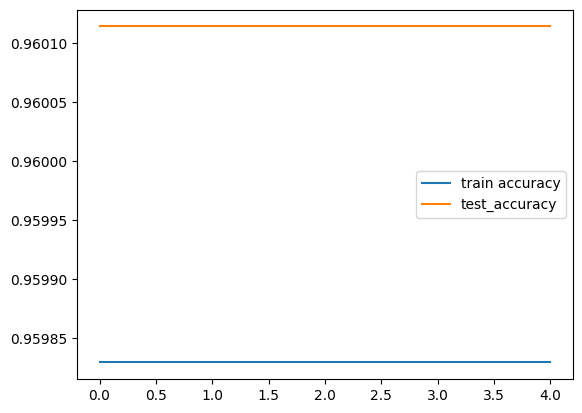

In [53]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

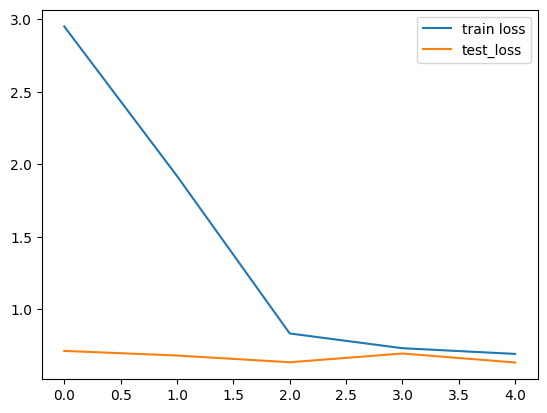

In [54]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

22/22 [==============================] - 10s 426ms/step


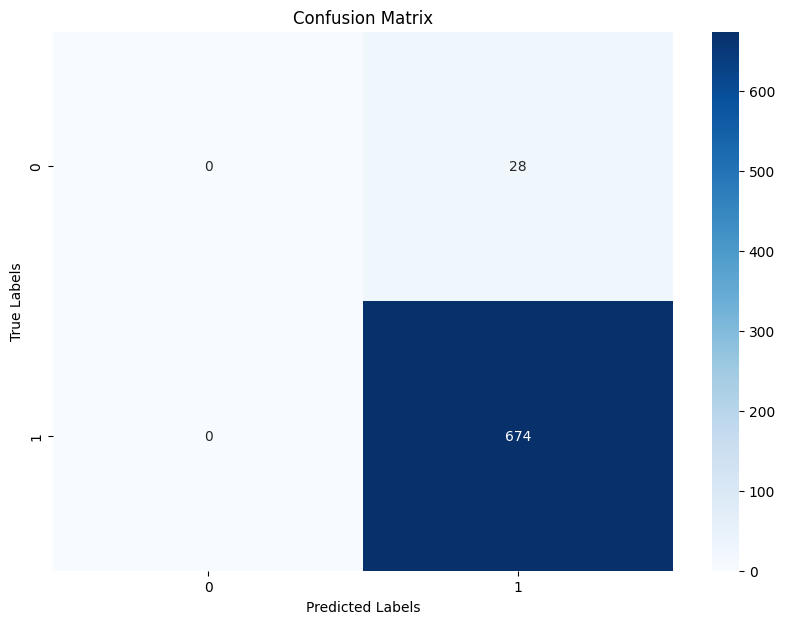

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                  precision    recall  f1-score   support

   Cardiomegaly       0.00      0.00      0.00        28
nonCardiomegaly       0.96      1.00      0.98       674

       accuracy                           0.96       702
      macro avg       0.48      0.50      0.49       702
   weighted avg       0.92      0.96      0.94       702



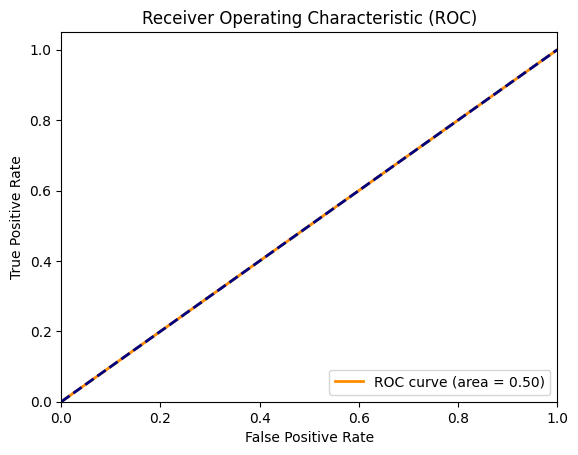

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming the model and val_generator are already defined
# Get the true labels and predicted probabilities
y_true = val_generator.classes
y_pred_proba = model.predict(val_generator, steps=len(val_generator))
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys())
print("Classification Report:\n", report)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [56]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp model.h5

In [57]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         288       ['input_10[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

In [27]:
# Import necessary libraries
from PIL import Image
from matplotlib import cm
import sys

# Define function to generate Grad-CAM visualization for given image and CNN model
def grad_cam(model, image, layer_name):

    # Define model that generates both final model predictions as well as output of chosen layer
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # Incoming image is singular example so expand dimensions to represent batch of size 1
    image_tensor = np.expand_dims(image, axis=0)

    # Cast image tensor to float32 type
    inputs = tf.cast(image_tensor, tf.float32)

    # Set up gradient tape to monitor intermediate variables and predictions
    with tf.GradientTape() as tape:

        # Extract activations from chosen layer and model's final predictions
        last_conv_layer_output, preds = grad_model(inputs)

        # Identify predicted class from final predictions
        pred_class = tf.argmax(preds[0])

        # Get output of predicted class from final layer
        class_channel = preds[:, pred_class]

    # Compute gradient of output with respect to chosen layer's output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Reduce 2D gradients to 1D by averaging across height and width dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply 2D output map of chosen layer by 1D pooled gradients
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to be between 0 and 1 for better visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Return Grad-CAM heatmap
    return heatmap.numpy()

(224, 224)


<ipython-input-61-5b3108c50e5f>:26: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = np.uint8(255 * grad_cam_image)


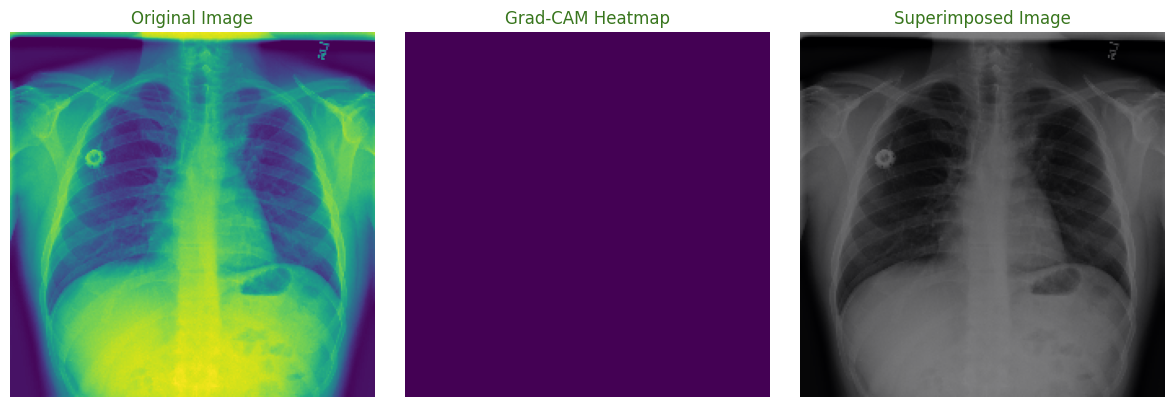

(224, 224)


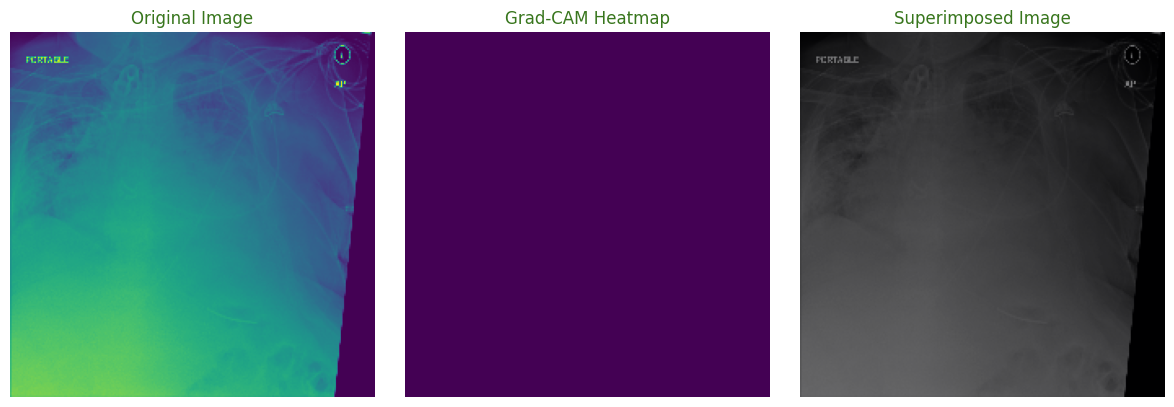

(224, 224)


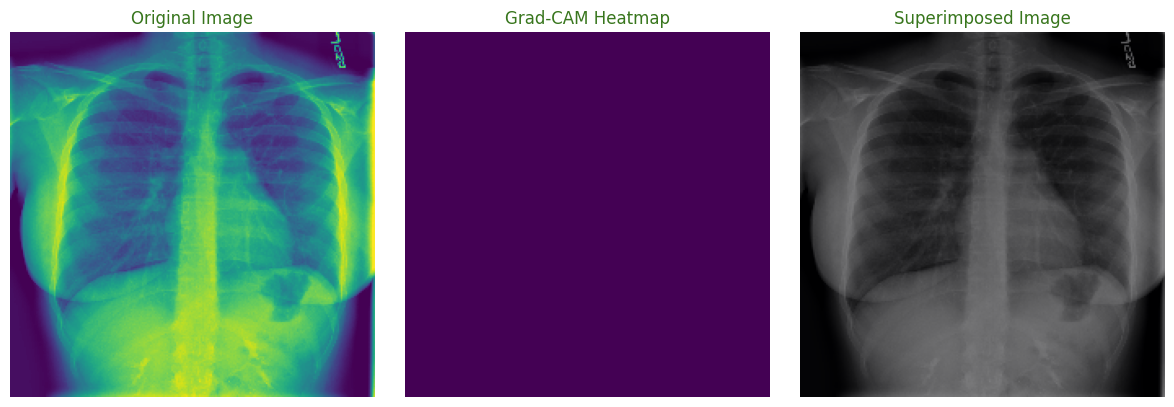

(224, 224)


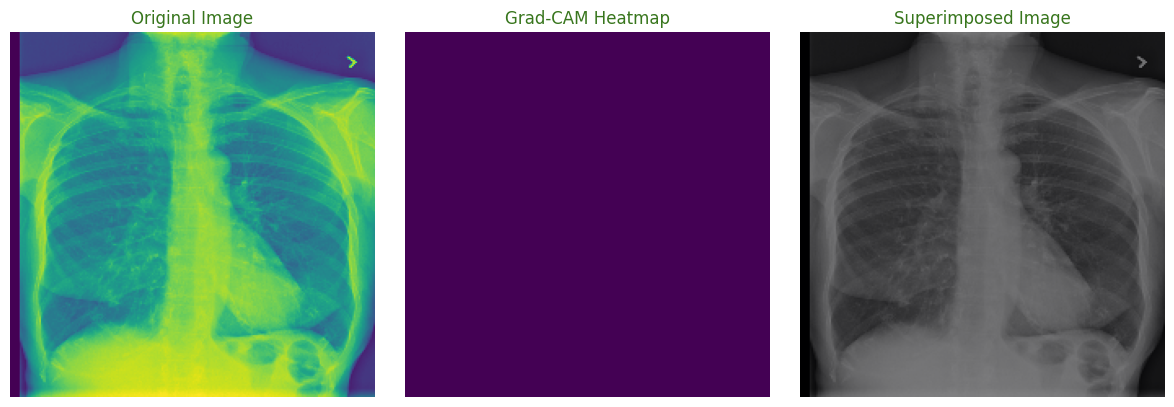

(224, 224)


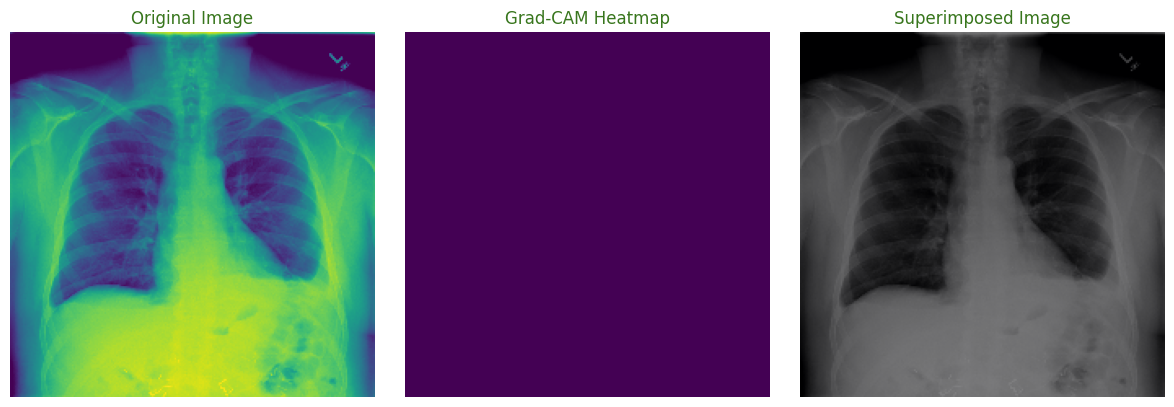

(224, 224)


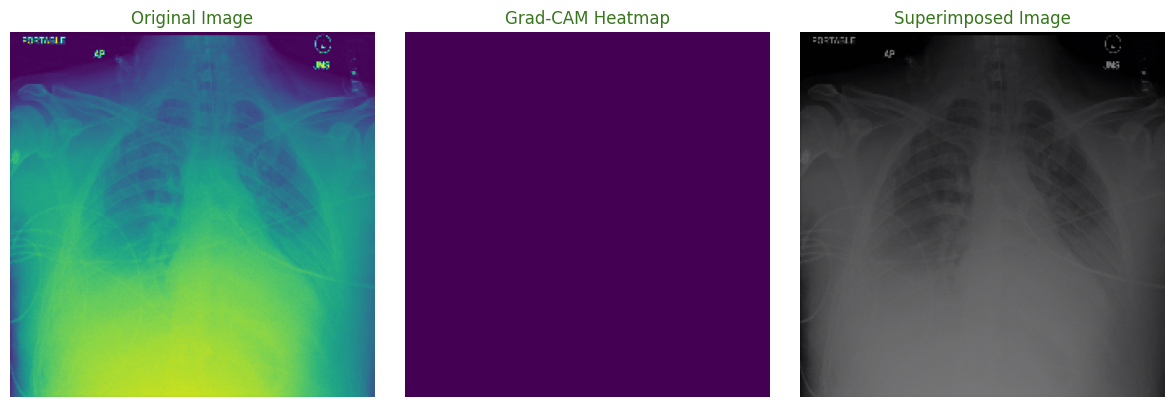

(224, 224)


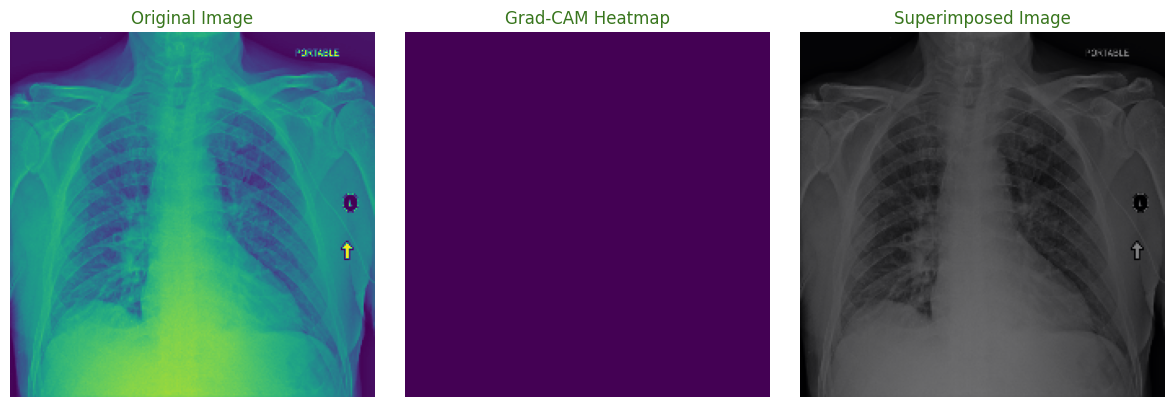

(224, 224)


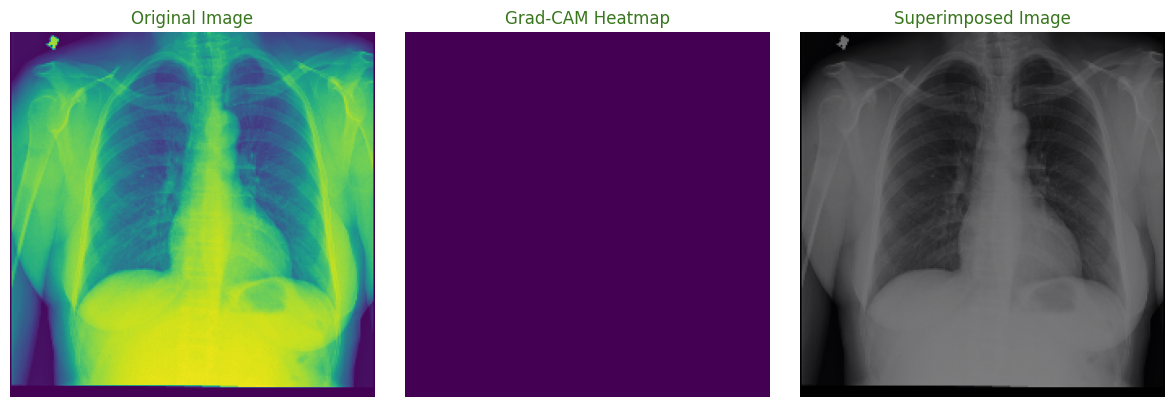

(224, 224)


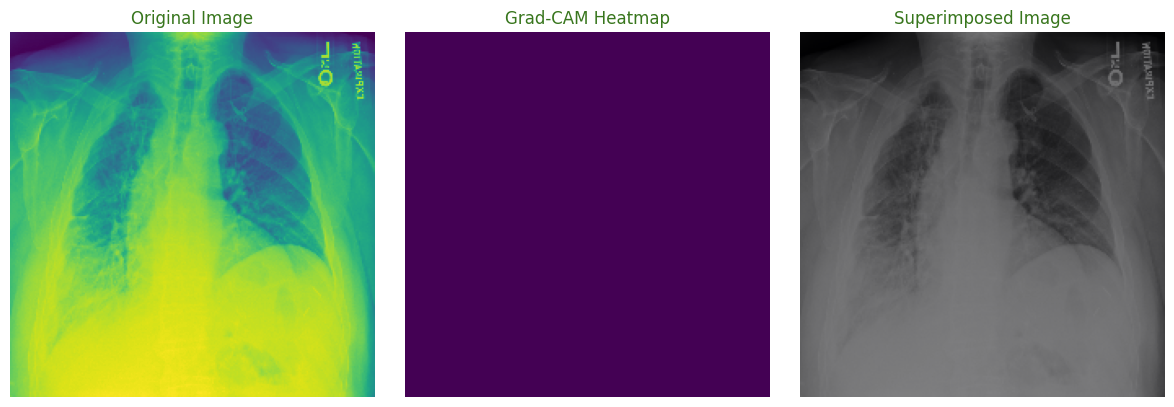

(224, 224)


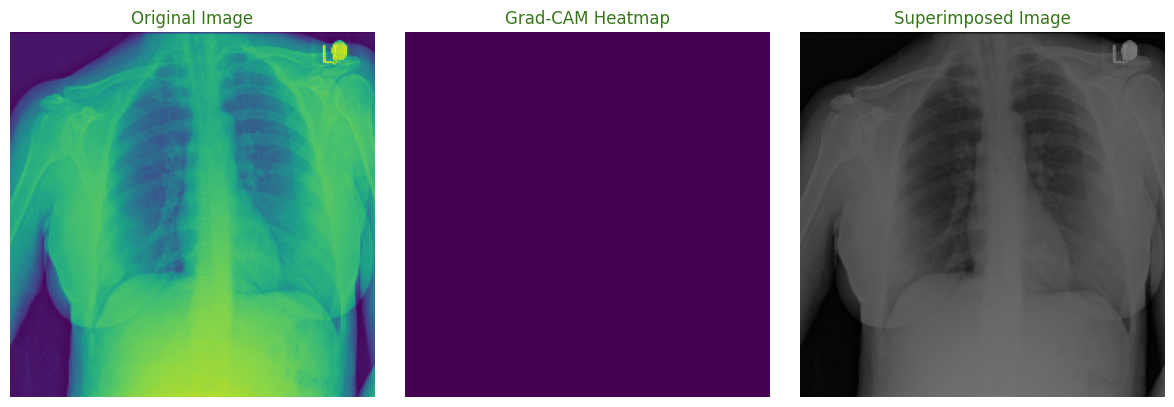

(224, 224)


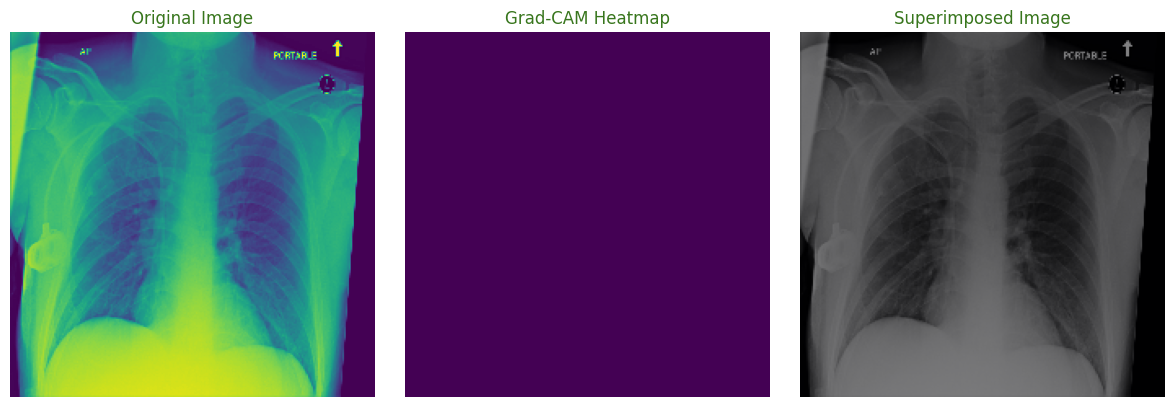

(224, 224)


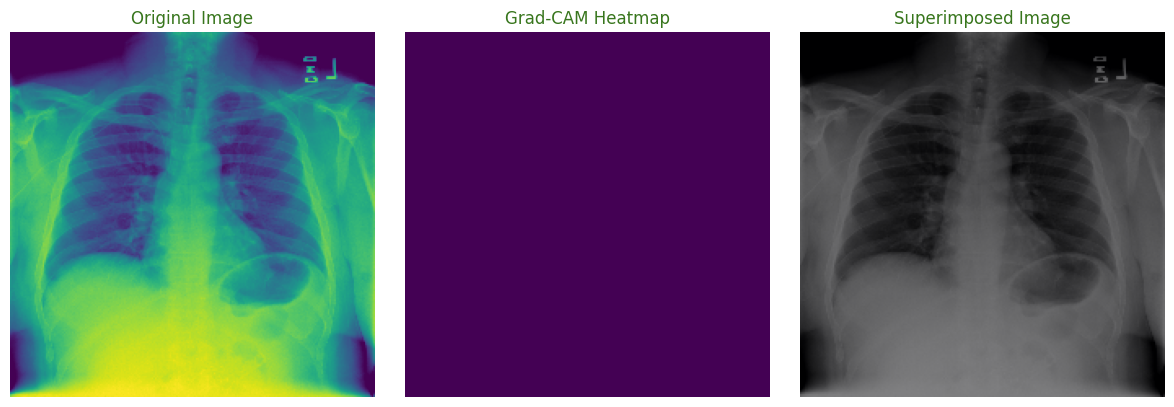

In [61]:
import glob
import cv2
import numpy as np
import tensorflow as tf
# Set number of images to display and generate random indices
num_images = 12
test_images = [i for i in glob.glob("/content/sample/images/*.png")]
image_indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Set layer name based on best performing CNN model for Grad-CAM visualization
layer_name = 'conv2d_39'

# Loop over random indices to generate Grad-CAM visualizations for multiple test images
for image_index in image_indices:

    # Choose test image and visualize using Grad-CAM
    image = cv2.imread(test_images[image_index],0)
    image = cv2.resize(image,(224,224))/255.0
    # cv2.imwrite('original.png', 255*image)
    print(np.shape(image))
    grad_cam_image = grad_cam(model, image, layer_name)

    # Enhance heatmap image for better visualization
    grad_cam_image = np.maximum(grad_cam_image, 0)
    grad_cam_image = np.minimum(grad_cam_image, 1)
    heatmap_colored = np.uint8(255 * grad_cam_image)
    # heatmap_colored = cm.jet(grad_cam_image)[:, :, :3]
    # heatmap_colored = np.uint8(255 * heatmap_colored)

    # Resize heatmap to original image size
    heatmap_resized = np.array(Image.fromarray(heatmap_colored).resize((image.shape[1], image.shape[0])))

    # Convert image and heatmap to 0-255 scale
    if image.max() <= 1:
        image = (image * 255).astype('uint8')
    if heatmap_resized.max() <= 1:
        heatmap_resized = (heatmap_resized * 255).astype('uint8')

    # Superimpose heatmap on original image, with more weight on original image
    # superimposed_image = heatmap_resized * 0.4 + image * 0.6
    # superimposed_image = np.clip(superimposed_image, 0, 255).astype('uint8')

    # Temporarily redirect standard output to null to suppress verbose output
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    # # Predict class of image using final hybrid model
    # test_feature = best_cnn_model.predict(np.expand_dims(image, axis=0))
    # predicted_class = final_hybrid_model.predict(test_feature)
    # predicted_class_name = class_names[np.argmax(predicted_class)]
    # actual_class_name = class_names[np.argmax(test_labels_xgb[image_index])]

    # Restore standard output to original state
    sys.stdout = original_stdout

    # Determine if prediction is correct
    # is_correct = (actual_class_name == predicted_class_name)

    # Assign title color based on prediction correctness
    title_color = '#38761D'

    # Set up plot for original, heatmap and superimposed images
    plt.figure(figsize=(12, 4))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Original Image', color=title_color)
    plt.axis('off')

    # Plot heatmap image
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized)
    plt.title('Grad-CAM Heatmap', color=title_color)
    plt.axis('off')

    # Plot superimposed image
    plt.subplot(1, 3, 3)
    # plt.imshow(superimposed_image.astype(np.uint8))
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap_resized, cmap='magma', alpha=0.5)
    plt.title(f'Superimposed Image', color=title_color)
    # Convert heatmap to a colored heatmap using a colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_MAGMA)

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB), 0.5, heatmap_colored, 0.5, 0)

    # Save the resulting image
    cv2.imwrite('merged_image.jpg', overlay)
    plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

    # Show plot
    plt.show()